## Data overview

In [71]:
# import libraries
import torch
import cv2
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from torch.nn import ConvTranspose2d, Conv2d, MaxPool2d, Module, ModuleList, ReLU
from torchvision.transforms import CenterCrop
from torch.utils.data import Dataset
from torch.nn import functional as F

from IPython.display import Image
from IPython.core.display import HTML 

In [72]:
# set the RNG
random.seed(777)

In [22]:
# base path of the dataset
DATASET_PATH = 'F:/Medical_DATA/MosMedData/'

In [53]:
# define the path to the images and masks dataset
IMAGE_DATASET_PATH = DATASET_PATH + 'studies/CT-1/'
MASK_DATASET_PATH = DATASET_PATH + 'masks/'

In [55]:
# load "study" image from path
test_study = nib.load(IMAGE_DATASET_PATH + 'study_0255.nii').get_fdata()
test_study.shape

(512, 512, 38)

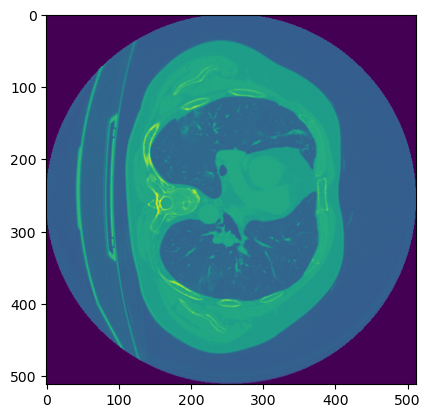

In [56]:
# plotting "study" image
test1 = test_study[:, :, 20]
plt.imshow(test1)
plt.show()

In [35]:
# load "mask" image from path
test_mask = nib.load(MASK_DATASET_PATH + 'study_0255_mask.nii').get_fdata()
test_mask.shape

(512, 512, 38)

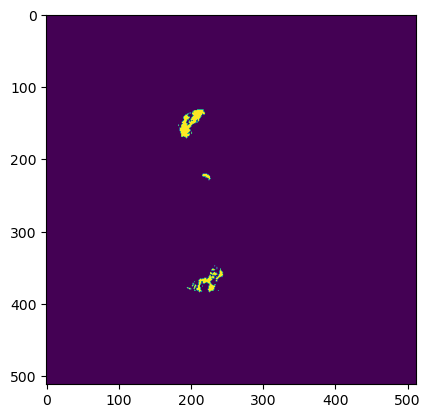

In [36]:
# plotting "mask" image
test2 = test_mask[:, :, 20]
plt.imshow(test2)
plt.show()

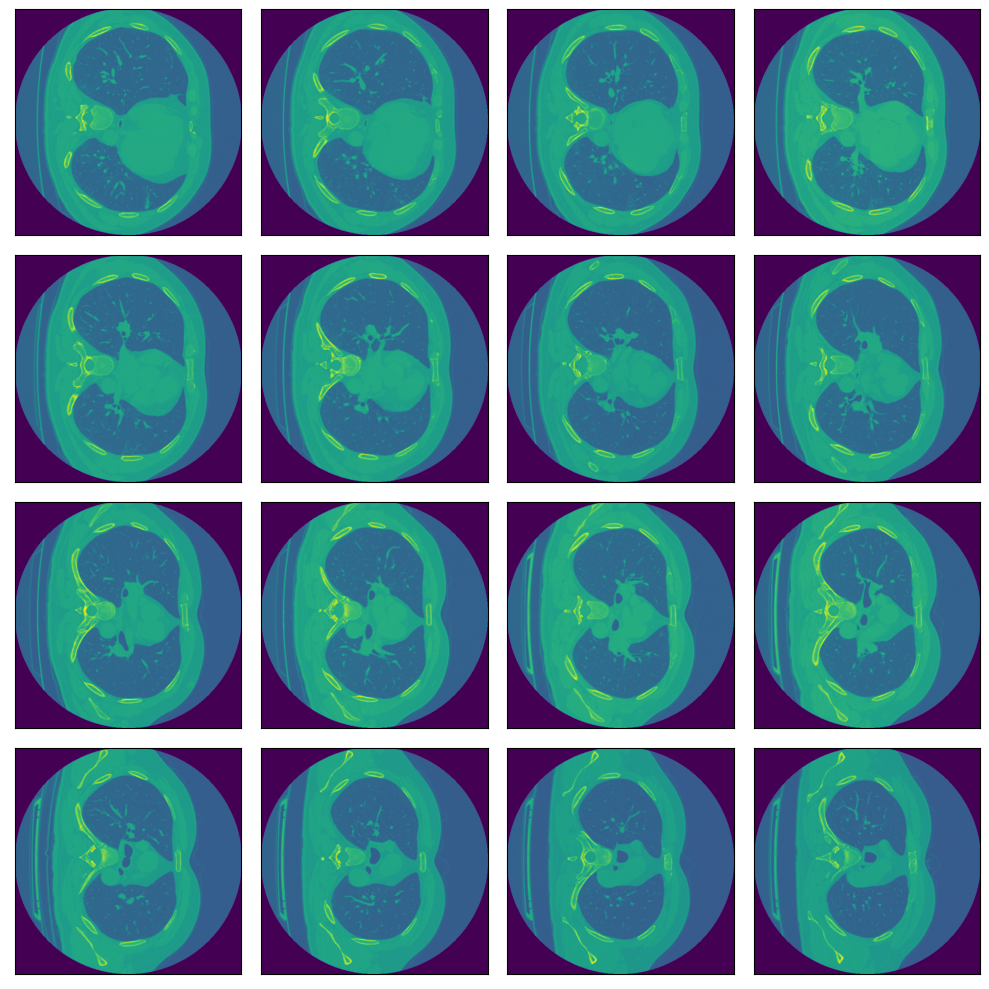

In [37]:
# print out "study" images from dataset
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(test_study[:, :, i + 15])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

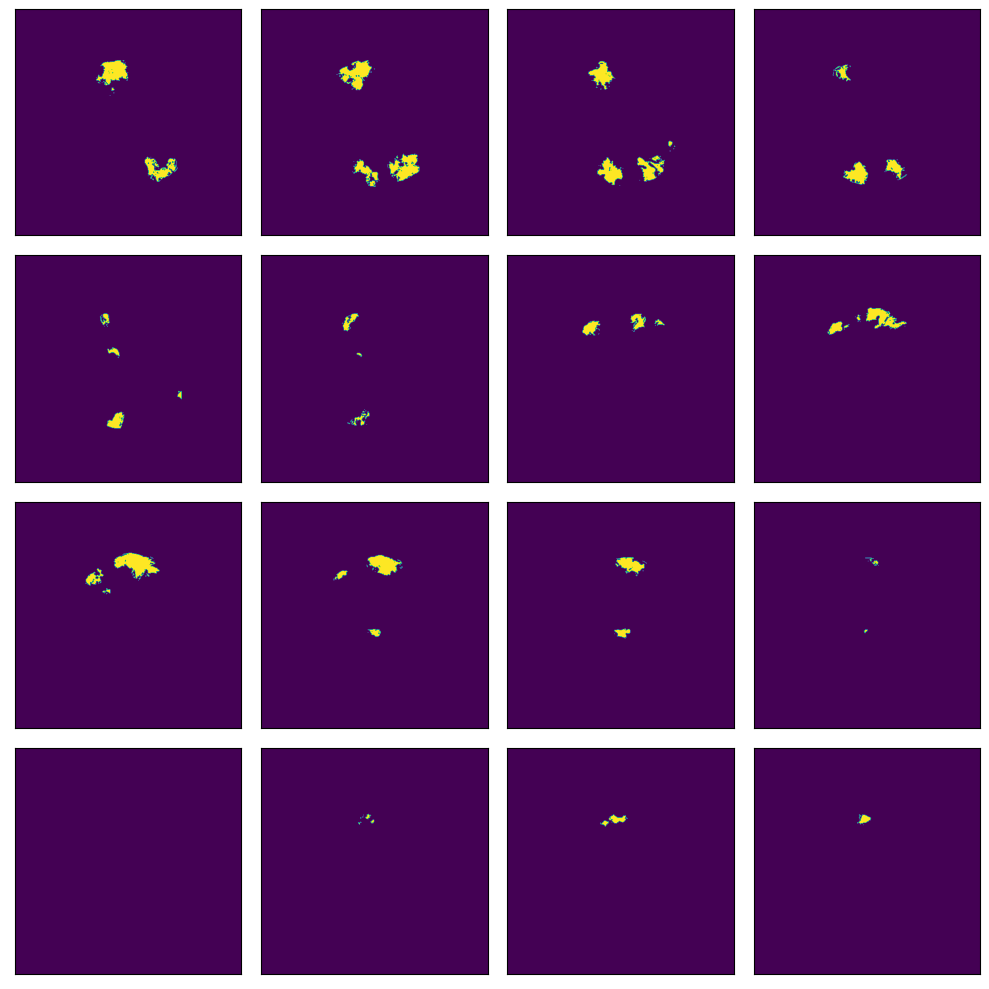

In [38]:
# print out "mask" images from dataset
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(test_mask[:, :, i + 15])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## U-Net architecture

In [69]:
# PyTorch U-Net
Image(url='https://media.springernature.com/full/springer-static/image/art%3A10.1186%2Fs12859-020-03943-2/MediaObjects/12859_2020_3943_Fig5_HTML.png?as=webp', 
      width=900, height=550
)

In [64]:
# details of U-Net operations
Image(url='https://theaisummer.com/static/65fb1cbb4f03b040de53075992047edd/83e77/vnet-model.png', 
      width=900, height=700
)

In [47]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 4

In [48]:
# initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 0.001
NUM_EPOCHS = 40
BATCH_SIZE = 64

In [49]:
# define the input image dimensions
INPUT_IMAGE_WIDTH = 512
INPUT_IMAGE_HEIGHT = 512

In [50]:
# define threshold to filter weak predictions
THRESHOLD = 0.5

In [73]:
# create custom segmentation dataset class
class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths, transforms):
		
        # store the image and mask filepaths, and augmentation transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths
		self.transforms = transforms
	
	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		mask = cv2.imread(self.maskPaths[idx], 0)
		
		# check to see if we are applying any transformations
		if self.transforms is not None:
			# apply the transformations to both image and its mask
			image = self.transforms(image)
			mask = self.transforms(mask)
		
		# return a tuple of the image and its mask
		return (image, mask)

In [76]:
# define a block module as the building unit of encoder and decoder architecture
class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		
        # store the convolution and RELU layers
		self.conv1 = Conv2d(inChannels, outChannels, kernel_size=3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, kernel_size=3)
    
	def forward(self, x):
		# apply CONV => RELU => CONV block to the inputs and return it
		return self.conv2(self.relu(self.conv1(x)))

In [79]:
# encode the input image into feature representations at multiple different levels
class Encoder(Module):
	def __init__(self, channels=(3, 32, 64, 128, 256)):
		super().__init__()
		
        # store the encoder blocks and maxpooling layer
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)]
        )
		self.pool = MaxPool2d(kernel_size=2)

	def forward(self, x):
		# initialize an empty list to store the intermediate outputs
		blockOutputs = []
		
		# loop through the encoder blocks
		for block in self.encBlocks:
			# pass the inputs through the current encoder block, store
			# the outputs, and then apply maxpooling on the output
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		
		# return the list containing the intermediate outputs
		return blockOutputs

In [80]:
# take the extracted features and reconstruct a segmentation mask
class Decoder(Module):
	def __init__(self, channels=(256, 128, 64, 32)):
		super().__init__()
		
		# initialize the number of channels, upsampler blocks, and decoder blocks
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], kernel_size=2, stride=2)
			 	for i in range(len(channels) - 1)]
		)
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)]
		)
	
	def forward(self, x, encFeatures):
		# loop through the number of channels
		for i in range(len(self.channels) - 1):
			# pass the inputs through the upsampler blocks
			x = self.upconvs[i](x)
			# crop the current features from the encoder blocks,
			# concatenate them with the current upsampled features,
			# pass the concatenated output through the current decoder block
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		
		# return the final decoder output
		return x
	
	def crop(self, encFeatures, x):
		# grab the dimensions of the inputs, and crop the encoder
		# features to match the dimensions
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		
		# return the cropped features
		return encFeatures

In [83]:
# build U-Net model class
class UNet(Module):
	def __init__(self, encChannels=(3, 32, 64, 128, 256),
				 decChannels=(256, 128, 64, 32),
				 nbClasses=1, retainDim=True,
				 outSize=(INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)):
		
		super().__init__()
		
		# initialize the encoder and decoder
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		
		# initialize the regression head and store the class variables
		self.head = Conv2d(decChannels[-1], nbClasses, kernel_size=1)
		self.retainDim = retainDim
		self.outSize = outSize

	def forward(self, x):
		# grab the features from the encoder
		encFeatures = self.encoder(x)
		
		# pass the encoder features through decoder making sure that
		# their dimensions are suited for concatenation
		decFeatures = self.decoder(encFeatures[::-1][0], encFeatures[::-1][1:])
		
		# pass the decoder features through the regression head to
		# obtain the segmentation mask
		map = self.head(decFeatures)
		
		# check to see if there is retaining the original output
		# dimensions and if so, then resize the output to match them
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		
		# return the segmentation map
		return map